In [1]:
import torch as tr
import numpy as np

import itertools

from PM_models import *
from PM_tasks import *
from help_amtask import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

# sweep 2
- evaluating effect of pre-training

In [2]:
nmaps = 4
fdir = 'model_data/amtask-barcode/'
nnets = 20
instdimL=[8,10,12]
stimdimL=[8,10,12]
stsizeL=[4,5,6,8]

In [17]:
def load_trsc2(st,inst,stim,seed,pretrain=False):
  if pretrain:
    curr = '1000_29000'
  else:
    curr = '0_30000'
  fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-curr_%s-seed_%i-trsc.npy"%(st,inst,stim,curr,seed)
  trsc = np.load(fdir+fpath)
  return trsc

def load_trsc(st,inst,stim,seed):
  fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-seed_%i-trsc.npy"%(st,inst,stim,seed)
  trsc = np.load(fdir+fpath)
  return trsc

def load_trsc_group(st,inst,stim,nnets=20,load_trsc_fn=load_trsc):
  L = []
  for seed in range(nnets):
    trsc = load_trsc_fn(st,inst,stim,seed)
    L.append(trsc)
  return np.array(L)

def plt_trsc(ax,trsc,mawind=500):
  '''trsc [sub,neps,ntr,trlen]'''
  cL = ['b','purple']
  for sub in range(len(trsc)):
    for trial in [0,1]:
      trsc_tr = trsc[sub,:,trial,nmaps:].mean(-1)
      tracc = mov_avg(trsc_tr,mawind)
      ax.plot(tracc,c=cL[trial],lw=.5,zorder=100*trial)
      ax.axhline(0.25,c='r',lw=.1,ls='--')
  return None


## training acc

FileNotFoundError: [Errno 2] No such file or directory: 'model_data/amtask-barcode/nmaps_4-ntrials_2-wmsize_8-instdim_8-stimdim_8-curr_0_30000-seed_2-trsc.npy'

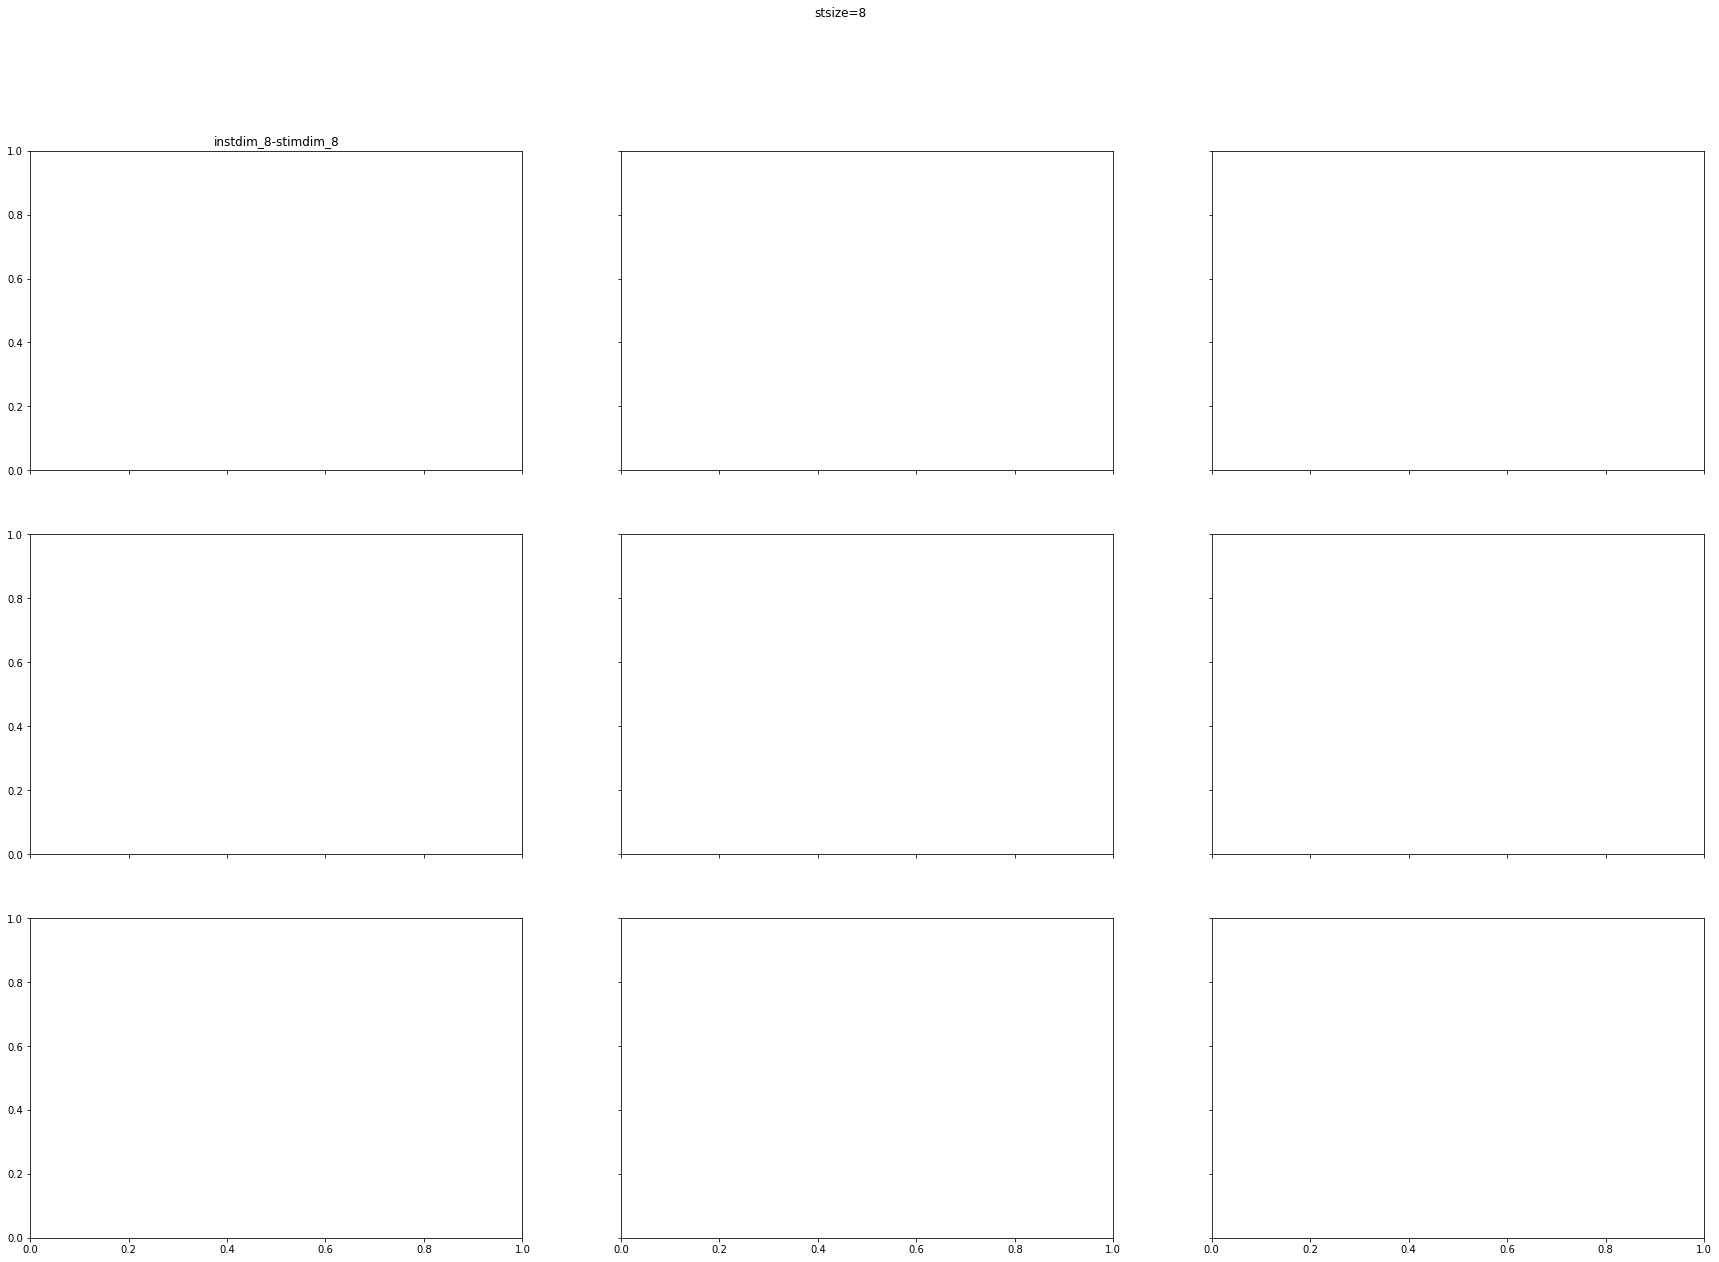

In [18]:
''' plot group '''
f=2
nnets = 10
for st in stsizeL:
  plt.close('all')
  fig,axarr = plt.subplots(3,3,figsize=(f*15,f*10),sharex=True,sharey=True);axarr=axarr.reshape(-1)
  plt.suptitle('stsize=%i'%st)
  for idx,(inst,stim) in enumerate(itertools.product(stimdimL,instdimL)):
    ax = axarr[idx]
    title = 'instdim_%i-stimdim_%i'%(inst,stim)
    ax.set_title(title)
    ## load group data
    trsc = load_trsc_group(st,inst,stim,nnets=nnets,load_trsc_fn=load_trsc2)
    ## plot group data
    plt_trsc(ax,trsc)
  plt.savefig('figures/amtask-barcodes/tracc/'+'sweep2-nopretrain-stsize-%i'%st)

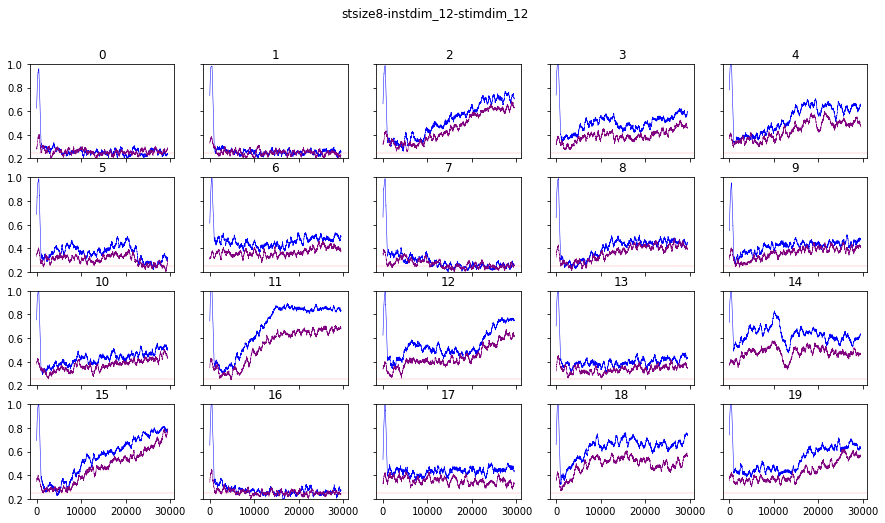

In [14]:
''' plot individual subjects '''
f=1
nnets = 20
for inst,stim,st in itertools.product(stimdimL,instdimL,stsizeL):
  ## load group data
  trsc = load_trsc_group(st,inst,stim,nnets=nnets,load_trsc_fn=load_trsc2)
  plt.close('all')
  fig,axarr = plt.subplots(4,5,figsize=(f*15,f*8),sharex=True,sharey=True);axarr=axarr.reshape(-1)
  title = 'stsize%i-instdim_%i-stimdim_%i'%(st,inst,stim)
  plt.suptitle(title)
  ## loop plot for different subjects
  for idx in range(nnets):
    ax = axarr[idx]
    ax.set_ylim(.2,1)
    ax.set_title(idx)
    ## plot group data
    plt_trsc(ax,trsc[idx:idx+1])
#   plt.savefig('figures/amtask-barcodes/tracc/'+'sweep2-pretrain-stsize%i-instdim_%i-stimdim_%i'%(st,inst,stim))



## eval acc

In [62]:
def load_evsc2(st,inst,stim,seed,pretrain=True):
  if pretrain: curr = '1000_29000'
  else: curr = '0_30000'
  L = []
  for em in [0,1]:
    fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-curr_%s-seed_%i-ev_em_%i-evsc.npy"%(st,inst,stim,curr,seed,em)
    trsc = np.load(fdir+fpath)
    L.append(trsc)
  return np.array(L)

def load_evsc(st,inst,stim,seed):
  L = []
  for em in [0,1]:
    fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-seed_%i-ev_em_%i-evsc.npy"%(st,inst,stim,seed,em)
    trsc = np.load(fdir+fpath)
    L.append(trsc)
  return np.array(L)

def load_evsc_group(st,inst,stim,nnets,load_data_fn=load_evsc):
  L = []
  for seed in range(nnets):
    trsc = load_data_fn(st,inst,stim,seed)
    L.append(trsc)
  return np.array(L)

In [63]:
def plt_trial_acc(ax,evsc,plt_subs=True):
  '''evsc [nsubs,(em0,em1),neps,ntr,trlen]
  '''
  evacc = evsc[:,:,:,:,nmaps:].mean((2,-1))
  M = evacc.mean(0)
  S = evacc.std(0)/np.sqrt(len(evacc))
  cL = ['r','b']
  ## plt eval with and without EM
  for em in [0,1]:
    ax.plot(M[em],c=cL[em],lw=2)
    ax.scatter(range(len(M[em])),M[em],c='k')
    ax.fill_between(range(len(M[em])),M[em]-S[em],M[em]+S[em],alpha=.3,color=cL[em])
    if plt_subs:
      for sacc in evacc:
        ax.plot(sacc[em],c=cL[em],lw=.1)
  return None


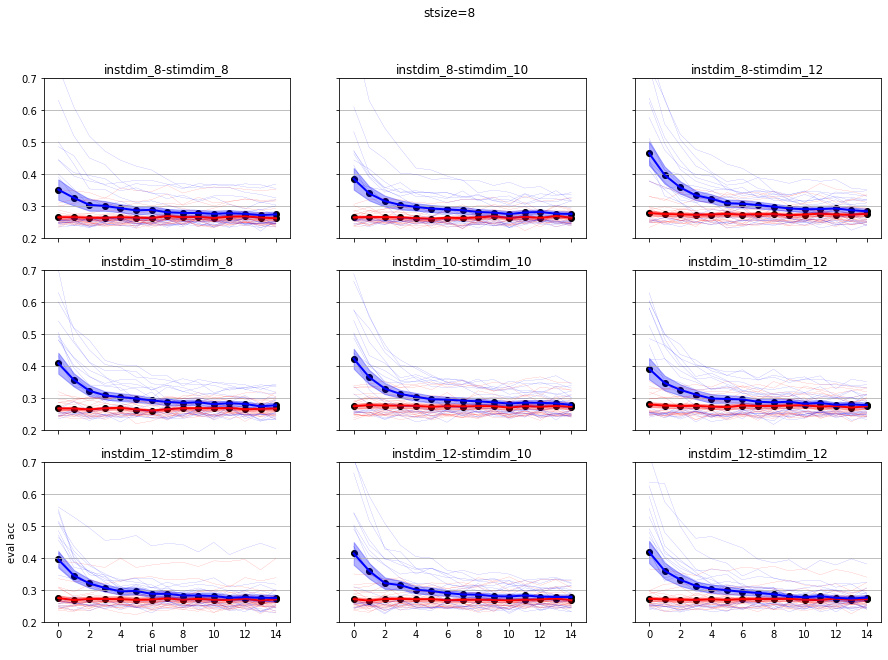

In [25]:
''' group plots comparing eval w/ vs w/o EM'''
f=1
nnets = 20
for st in stsizeL:
  plt.close('all')
  fig,axarr = plt.subplots(3,3,figsize=(f*15,f*10),sharex=True,sharey=True);axarr=axarr.reshape(-1)
  axarr[6].set_xlabel('trial number')
  axarr[6].set_ylabel('eval acc')
  plt.suptitle('stsize=%i'%st)
  for idx,(inst,stim) in enumerate(itertools.product(stimdimL,instdimL)):
    ax = axarr[idx]
    ax.grid(axis='y')
    ax.set_ylim(0.2,0.7)
    title = 'instdim_%i-stimdim_%i'%(inst,stim)
    ax.set_title(title)
    ## load group data
    evsc = load_evsc_group(st,inst,stim,nnets,load_data_fn=load_evsc2)
    ## plot
    plt_trial_acc(ax,evsc)
  plt.savefig('figures/amtask-barcodes/evacc/'+'sweep2_pretrain-stsize_%i'%st)

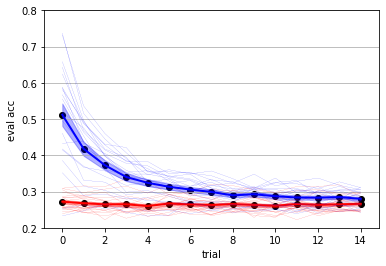

In [64]:
''' best group '''
st,inst,stim = 6,10,12
evsc = load_evsc_group(st,inst,stim,nnets,load_data_fn=load_evsc2)
ax=plt.gca()
ax.set_ylim(.2,.8)
ax.grid(axis='y')
plt_trial_acc(ax,evsc)
ax.set_xlabel('trial')
ax.set_ylabel('eval acc')
plt.savefig('figures/amtask-barcodes/evacc/st6-inst10-stim12-sweep2')

In [67]:
evsc.shape

(20, 2, 500, 15, 9)

subject mean acc:
 [0.60994074 0.63863704 0.64863704 0.61724444 0.58398519 0.58285926
 0.63114074 0.63354074 0.6122963  0.65348148 0.59884444 0.65333333
 0.63336296 0.64167407 0.63373333 0.63762963 0.5253037  0.63311111
 0.6546963  0.59565926]
highest acc subj:
 18


(20, 2, 500, 15, 9)

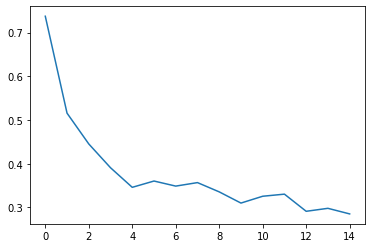

In [68]:
print('subject mean acc:\n',evsc[:,1].mean((-1,-2,-3))) 
print('highest acc subj:\n',np.argmax(evsc[:,1].mean((-1,-2,-3))))
plt.plot(evsc[18,1,:,:,nmaps:].mean((0,2)))


## load net

- analyze best training group st6,inst10,stim12

In [69]:
def load_net(wmsize,inst,stim,seed,pretrain=True):
  if pretrain: curr = '1000_29000'
  else: curr = '0_30000'
  fpath = "nmaps_4-ntrials_2-wmsize_%i-instdim_%i-stimdim_%i-curr_%s-seed_%i-model.pt"%(wmsize,inst,stim,curr,seed)
  net = NetBarCode(wmsize=wmsize,emsetting=1,seed=seed,instdim=inst,stimdim=stim,debug=False)
  net.load_state_dict(tr.load(fdir+fpath,map_location=tr.device('cpu')))
  return net

def load_netL(wmsize,inst,stim,nnets=20):
  netL = []
  for seed in range(nnets):
    net = load_net(wmsize,inst,stim,seed)
    netL.append(net)
  return netL

In [73]:
stimdim = 12
netL = load_netL(6,10,stimdim)
seed = 18
task = TaskArbitraryMaps(nmaps,switchmaps=True,ntokens_surplus=0,seed=seed,stimdim=stimdim)
net = netL[seed]

In [81]:
neps,ntr,trlen=1,3,1
net.debug=True
evsc = run_net(net,task,neps,ntr,trlen,training=False)


st tensor(0.1050)
wm tensor(-0.7920)
em tensor(0.)

st tensor(0.6504)
wm tensor(0.7423)
em tensor(0.)

st tensor(0.7143)
wm tensor(-0.7243)
em tensor(0.)

st tensor(0.1974)
wm tensor(0.7184)
em tensor(0.)

qkdist2 [0.    0.267 0.846 0.216]

st tensor(0.1050)
wm tensor(-0.7551)
em tensor(-0.7920)

st tensor(0.7362)
wm tensor(-0.7647)
em tensor(0.)

st tensor(0.7143)
wm tensor(-0.7575)
em tensor(0.)

st tensor(0.1050)
wm tensor(0.7255)
em tensor(0.)

st tensor(0.1974)
wm tensor(0.7607)
em tensor(0.)

qkdist2 [0.    0.267 0.846 0.216 0.802 0.846 0.    0.216]

st tensor(0.1050)
wm tensor(-0.7550)
em tensor(-0.7920)

st tensor(0.7362)
wm tensor(-0.7716)
em tensor(0.)

st tensor(0.1050)
wm tensor(0.7215)
em tensor(0.)

st tensor(0.6504)
wm tensor(0.7465)
em tensor(0.)

st tensor(0.1974)
wm tensor(-0.7525)
em tensor(0.)

qkdist2 [0.802 0.815 0.011 0.953 0.    0.011 0.802 0.953 0.    0.802 0.815 0.953]

st tensor(0.7362)
wm tensor(-0.7402)
em tensor(-0.7647)
0.0 0.8666666666666667


# train and eval

In [132]:
emsetting=1
wmsize=5
instdim=10
stimdim=12
seed=0

net = NetBarCode(wmsize=wmsize,
                 emsetting=emsetting,
                 seed=seed,
                 instdim=instdim,
                 stimdim=stimdim,
                 debug=False)

nmaps = 4
task = TaskArbitraryMaps(nmaps,
                         switchmaps=True,
                         ntokens_surplus=0,
                         seed=seed,
                         stimdim=stimdim)

In [133]:
trscL = []
emkL = ['stim','conj','stim','conj']
nepsL = [500,10000,500,1000]

for idx in range(len(nepsL)):

  net.emk=emkL[idx]
  trsc = run_net(net,task,nepsL[idx],3,1,training=True,verb=True)
  trscL.append(trsc[:,:,nmaps:])
trsc = np.concatenate(trscL)

0.0 0.0
0.2 0.6666666666666666
0.4 0.9333333333333333
0.6 0.8666666666666667
0.8 0.8
0.0 0.8666666666666667
0.2 0.9333333333333333
0.4 1.0
0.6 0.8666666666666667
0.8 0.8
0.0 0.9333333333333333
0.2 0.9333333333333333
0.4 0.8666666666666667
0.6 0.9333333333333333
0.8 0.8666666666666667
0.0 0.9333333333333333
0.2 0.9333333333333333
0.4 0.8666666666666667
0.6 0.9333333333333333
0.8 0.9333333333333333


In [134]:
print(trsc.shape)
tracc = trsc.mean((2)) 
print(tracc.shape)

(12000, 3, 1)
(12000, 3)


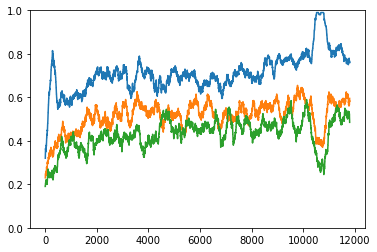

In [136]:
plt.ylim(0,1)
for acc in tracc.T:
  plt.plot(mov_avg(acc,200))

In [111]:
# net.debug=False
# for em in [1,0]:
#   net.EMsetting=em
#   evsc = run_net(net,task,500,10,2,training=False)
#   evacc = evsc[:,:,nmaps:]
#   plt.plot(evacc.mean((0,2)))